# Dataset

**[Income Dataset](https://www.kaggle.com/mastmustu/income)**

Binary classification to predict if income is greater that $50,000

# Import Libraries

In [212]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, classification_report, plot_roc_curve, roc_auc_score

In [213]:
# import training and test data

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# I. Wrangle Data

In [214]:
#wrangle function

def wrangle(filename):
    df = filename.copy()
    
    #drop duplicate column
    drop_cols = ['education','native-country','workclass','fnlwgt']
    df.drop(columns=drop_cols, inplace=True)
    
    #change 'gender' to binary values
    df['gender'] = df['gender'].apply(lambda x: 1 if x=='Male' else 0)
    
    return df

df = wrangle(train)

In [215]:
df.head()

,age,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,income_>50K
0,67,16,Divorced,Exec-managerial,Not-in-family,White,1,99999,0,60,1
1,17,8,Never-married,Other-service,Own-child,White,1,0,0,15,0
2,31,13,Married-civ-spouse,Exec-managerial,Husband,White,1,0,0,40,1
3,58,4,Married-civ-spouse,Transport-moving,Husband,White,1,0,0,40,0
4,25,10,Never-married,Other-service,Not-in-family,Black,1,0,0,40,0


# II. Split Data

In [216]:
# Split into features and target sets

target = 'income_>50K'
y = df[target]
X = df.drop(columns=target)

In [217]:
# split into train and validation sets

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [218]:
# Check datasets

assert len(X_train) == int(len(X)*.8)
assert len(y_train) == int(len(y)*.8)
assert len(X_val) == len(X)-len(X_train)
assert len(y_val) == len(X)-len(y_train)

# III. Baseline

In [219]:
print('Baseline Accuracy: ', y_train.value_counts(normalize=100).max())

Baseline Accuracy:  0.761637992321911


# IV. Build Model

**Logistic Regression Model**

In [220]:
model_lr = make_pipeline(OrdinalEncoder(),
                        SimpleImputer(),
                        StandardScaler(),
                        LogisticRegression(n_jobs=-1))


In [221]:
model_lr.fit(X_train,y_train);

**Random Forest Classifier Model**

In [222]:
model_rf = make_pipeline(OrdinalEncoder(),
                      SimpleImputer(),
                      StandardScaler(),
                      RandomForestClassifier(n_estimators=10,
                                             n_jobs=-1,
                                             random_state=42)
                     )

In [223]:
model_rf.fit(X_train,y_train);

## This section is for the Heroku app

In [224]:
from joblib import dump

dump(model_rf, 'pipeline.joblib', compress=True)

['pipeline.joblib']

In [225]:
import joblib
import sklearn
import category_encoders as ce

print(f'joblib=={joblib.__version__}')
print(f'scikit-learn=={sklearn.__version__}')
print(f'category_encoders=={ce.__version__}')

joblib==1.0.0
scikit-learn==0.24.0
category_encoders==2.2.2


# V. Check Metrics

**Logistic Regression**

In [226]:
print('Training Accuracy:', model_lr.score(X_train, y_train))
print('Validation Accuracy:', model_lr.score(X_val, y_val))

Training Accuracy: 0.8435376084174605
Validation Accuracy: 0.8445177434030937


**Random Forest Classifier**

In [227]:
print('Training Accuracy:', model_rf.score(X_train, y_train))
print('Validation Accuracy:', model_rf.score(X_val, y_val))

Training Accuracy: 0.9528224086449595
Validation Accuracy: 0.8409918107370337


**Confusion Matrix**

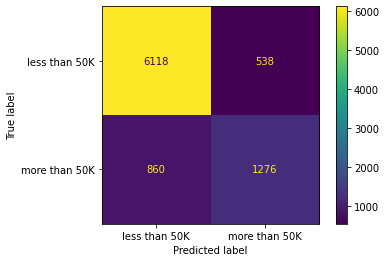

In [228]:
plot_confusion_matrix(model_rf,
                     X_val,
                     y_val,
                     values_format='.0f',
                     display_labels=['less than 50K', 'more than 50K'])

**Logistic Regression Precision and Recall**

In [229]:
print(classification_report(y_val,
                           model_lr.predict(X_val),
                           target_names=['less than 50K', 'more than 50K']))

               precision    recall  f1-score   support

less than 50K       0.87      0.93      0.90      6656
more than 50K       0.73      0.57      0.64      2136

     accuracy                           0.84      8792
    macro avg       0.80      0.75      0.77      8792
 weighted avg       0.84      0.84      0.84      8792



**Random Forest Classifier Precision and Recall**

In [230]:
print(classification_report(y_val,
                           model_rf.predict(X_val),
                            target_names=['less than 50K', 'more than 50K']))

               precision    recall  f1-score   support

less than 50K       0.88      0.92      0.90      6656
more than 50K       0.70      0.60      0.65      2136

     accuracy                           0.84      8792
    macro avg       0.79      0.76      0.77      8792
 weighted avg       0.83      0.84      0.84      8792



**ROC Curve**

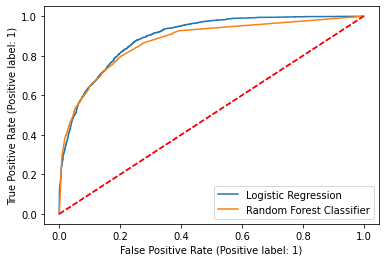

In [231]:
lr = plot_roc_curve(model_lr, X_val, y_val, label = 'Logistic Regression')
rf = plot_roc_curve(model_rf, X_val, y_val, label = 'Random Forest Classifier', ax=lr.ax_)
plt.plot(([(0,0),(1,1)]), color='red', linestyle='--')
plt.legend();

**ROC-AUC Score**

In [232]:
print('Logistic Regression ROC-AUC: ', roc_auc_score(y_val, model_lr.predict(X_val)))
print('Forest Regression ROC-AUC: ', roc_auc_score(y_val, model_rf.predict(X_val)))

Logistic Regression ROC-AUC:  0.7501116955668395
Forest Regression ROC-AUC:  0.7582744751152407


# VI. Tune Model

Since the ROC-AUC of the Random Forest Classifier is higher, we will tune hyperparameters of the random forest model to get the highest accuracy.

**Random Forest Classifier**


- `max_depth`
- `max_features`
- `n_estimators`

In [233]:
from sklearn.model_selection import RandomizedSearchCV

params = {
    'randomforestclassifier__max_depth': range(10,100,10),
    'randomforestclassifier__max_features': range(2,10,1),
    'randomforestclassifier__n_estimators': range(75,85,2)
}

rand_rf = RandomizedSearchCV(model_rf,
                             param_distributions=params,
                             n_iter=15,
                             n_jobs=-1,
                             verbose=1)

In [234]:
rand_rf.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


/Users/joanvillar/.local/share/virtualenvs/Lambda-TXy-paXc/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


RandomizedSearchCV(estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=['marital-status',
                                                                   'occupation',
                                                                   'relationship',
                                                                   'race'],
                                                             mapping=[{'col': 'marital-status',
                                                                       'data_type': dtype('O'),
                                                                       'mapping': Married-civ-spouse       1
Divorced                 2
Widowed                  3
Never-married            4
Separated                5
Married-spouse-absent    6
Married-AF-spouse        7
NaN                     -2
dtype: int64},
                                                                      {'col': 'occupation',
              

In [235]:
rand_rf.best_params_

{'randomforestclassifier__n_estimators': 83,
 'randomforestclassifier__max_features': 7,
 'randomforestclassifier__max_depth': 10}

In [236]:
rand_rf.best_score_

0.8636997014076495

In [246]:
print('Training Accuracy: ',rand_rf.score(X_train,y_train))
print('Validation Accuracy: ',rand_rf.score(X_val,y_val))

Training Accuracy:  0.8718043509171051
Validation Accuracy:  0.8620336669699727


In [238]:
rand_rf.score(X_val,y_val)

0.8620336669699727

# VII. Communicate Results

<AxesSubplot:>

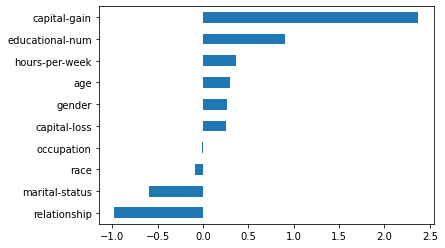

In [239]:
coefs = model_lr.named_steps['logisticregression'].coef_[0]
features = model_lr.named_steps['ordinalencoder'].get_feature_names()
pd.Series(coefs, index=features).sort_values().plot(kind='barh')

<AxesSubplot:>

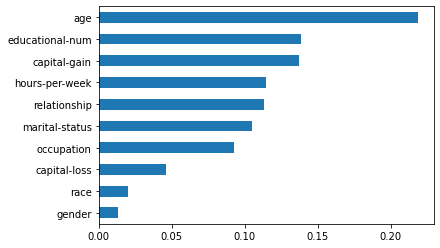

In [240]:
# make feature importance

importances = model_rf.named_steps['randomforestclassifier'].feature_importances_
features = X_train.columns

pd.Series(importances, index=features).sort_values().plot(kind='barh')